# Derivation

Wind farms are typically modeled using a ground up approach, beginning with individual wind turbine wakes in a single direction and speed. For each wind direction and wind speed combination, the wind turbine wakes are combined to approximate the velocity at each wind turbine, from which the power production in each direction/speed combination can be determined. The power production values in each direction/speed combination are then combined with probability distributions in the direction and speed dimensions to arrive at a final approximation for the wind farm annual energy production (AEP). This approach means that we have to compute turbine to turbine interactions for each pair of wind turbines for each direction/speed combination. For gradient-based optimization, we also have to compute the derivatives of each turbine to turbine interaction. However, due to the stochastic nature of the wind conditions at a wind farm, a coarser approach estimates average turbine pair interactions rather than calculating turbine pair interactions in every direction may work just as well for predicting AEP while giving us an added benefit of reducing the the computational cost to $O(n^2)$. In hard numbers, a wind farm with 81 turbines and a wind rose with 360 directions with only one wind speed per direction requires all turbine pair interactions to be checked for every wind direction, resulting in about 2,361,960 turbine interaction calculations to estimate the AEP a single time. In contrast, our new turbine pair interaction approach should require only 6,561 turbine interaction calculations. Our current model, implemented in julia, can predict AEP within $3\%$ compared with a typical engineering model in julia at a speedup of about $10\times$ on average for a wind farm with 60 turbines and 72 wind directions. This is a rough draft of the approach, and improved speedup and accuracy are expected.

The turbine pair interaction model is derived from the basic wake model and wind farm equations where the downstream distance is converted to a radial function by replacing the downstream distance $x$ with a radial turbine separation distance $r=\sqrt{x^2+y^2}$ and the interaction probability is determined by the direction between the current pair of turbines. The derivation of the model is as follows:

Wind farm AEP is modeled as shown in \cref{eq:aep},
\begin{equation}\label{eq:aep}
	AEP = \bigg(\frac{hours}{day}\bigg)\bigg(\frac{days}{year}\bigg) \sum_{k=1}^{N_D}f_k\sum_{i=1}^{N_T}P_{ik}(\hat{u}_{ik})
\end{equation}
where the power $P$ is defined as \cref{eq:power}
\begin{equation}\label{eq:power}
	P_{i_k} = 
		\begin{cases} 
		0 & \hat{u}_i < u_{cutin} \\
		0.5\rho A_i C_{P_i}\hat{u}_i^3 & \hat{u}_i \geq  u_{cutin} \ \text{and} \ P_{i} < P_{rated} \\
		P_{rated} & P_{i} \geq P_{rated}
	\end{cases}
\end{equation}
%
With the velocity $\bar{u_i}$ coming from a simple wake model and wake combination model. For our new model, we take the probability inside the velocity function and our AEP model becomes \cref{eq:aeprbf}.
\begin{equation}\label{eq:aeprbf}
	AEP = \bigg(\frac{hours}{day}\bigg)\bigg(\frac{days}{year}\bigg) \sum_{i=1}^{N_T}P_{i}(\hat{u}_{i})
\end{equation}
%
Our power model does not change, but our directional probability based velocity model is \cref{eq:urbf}.
%
\begin{equation}\label{eq:urbf}
	\hat{u}_{i} = \bar{u} - \sqrt{\sum_{j=1}^{N_T}\Big(\bar{u}_j f_{ij}2a\Big(\frac{d_{o,j}}{d_{o,j}+2\alpha r}\Big)^2\Big)^2}
\end{equation}
With the probability $f_{i,j}$ and the directional velocity $\bar{u}_j$ estimated from the direction between the wind turbines and $r$ being the direct distance between the turbine pair, turbines $i$ and $j$. The average velocity for the wind site is given by $\bar{u}$.


# Code

In [2]:

using DelimitedFiles 
using PyPlot
using FLOWMath: Akima
using QuadGK
using ProfileView
using BenchmarkTools
import FlowFarm; const ff = FlowFarm

"""
Convert angle from cartesian coordinate system to meterological coordinate system
"""
function cart2met(wind_direction_cart)

    # convert from cart. polar system (CCW, 0 rad.=E) to meteorological polar system (CW, 0 rad.=N) 
    wind_direction_met = 3.0*pi/2.0 - wind_direction_cart

    # adjust to be between 0 and 2pi
    if wind_direction_met < 0.0
        wind_direction_met += 2.0*pi
    end
    
    return wind_direction_met
end

┌ Info: Precompiling FlowFarm [eb2d4cfc-2064-11ea-0a1c-63d372e6a848]
└ @ Base loading.jl:1260
┌ Warning: Package FlowFarm does not have CCBlade in its dependencies:
│ - If you have FlowFarm checked out for development and have
│   added CCBlade as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with FlowFarm
└ Loading CCBlade into FlowFarm from project dependency, future warnings for FlowFarm are suppressed.


cart2met

In [133]:
# first create the necessary functions
function wake_combination_model(deficit, wind_speed, old_deficit_sum)
    # Katic et al. 1986

    new_deficit_sum = sqrt(old_deficit_sum^2 + (wind_speed*deficit)^2)
    # println("new_deficit_sum: ", new_deficit_sum)
    if new_deficit_sum > wind_speed
        new_deficit_sum = wind_speed
    end

    return new_deficit_sum

end

# get angle for two given turbines
function get_angle(dx, dy)
    angle = atan(dy,dx)
end

# get probability for a given angle
function get_probability_spline(wind_rose)
    p_spline = Akima(wind_rose[:,1], wind_rose[:,3])
    return p_spline
end

# get speed for a given angle
function get_speed_spline(wind_rose)
    speed_spline = Akima(wind_rose[:,1], wind_rose[:,2])
    return speed_spline
end

# get effective velocity for a given turbine
function get_effvelocity(turbid, x, y, wind_rose, uave, probability_spline, speed_spline; r0=0.5, alpha=0.1, a=1.0/3.0)
    nturbines = length(x)
    deficit_sum = 0.0
    for j = 1:nturbines
        dx = x[j] - x[turbid]
        dy = y[j] - y[turbid]
        dr = sqrt(dx^2+dy^2)
        angle = 180.0*cart2met(get_angle(dx, dy))/pi
#         p = get_probability(angle, wind_rose)
#         get_probability(dummy) = get_probability(dummy, wind_rose)
#         println(angle)
#         angles = angle-dr
        z = r0/alpha
        beta = 180.0*atan(alpha)/pi
        p=0.0
        wind_speed = 0.0
        counter = 0
        for ang in (angle-beta*0.25):1:(angle+beta*0.25)
#         for ang in (angle):(angle)
            p += probability_spline(ang)
            wind_speed += speed_spline(ang)
            counter += 1
        end
        wind_speed /= counter
#         p, perr = quadgk(get_probability, angle-alpha, angle+alpha)
        deficit = p*2.0*a*(r0/(r0+alpha*dr))^2
        
        deficit_sum = wake_combination_model(deficit, wind_speed, deficit_sum)
    end
#     deficit = sqrt((4.0*a^2)*deficit)
    
    ueff = uave - deficit_sum
    return ueff
end

# get effective cp for a turbine in a given direction
function get_cp_spline(cpct)
    cp_spline = Akima(cpct[:,1], cpct[:,2])
    return cp_spline
end

# get average wind speed
function get_ave_wind_speed(wind_rose)
    wind_speeds = wind_rose[:,2]
    probabilities = wind_rose[:,3]
    ave_speed = sum(wind_speeds.*probabilities)
    return ave_speed
end

# get average power for a given turbine
function get_effpower(turbid, x, y, wind_rose, uave, probability_spline, speed_spline, cp_spline;prated=5E6, u_cut_in=3.0, u_cut_out=25.0, density=1.225, r0=0.5, alpha=0.1, a=1.0/3.0)
    area = pi*r0^2
    ueff = get_effvelocity(turbid, x, y, wind_rose, uave, probability_spline, speed_spline, r0=r0)
    peff = 0.0
    
    if ueff < u_cut_in
        return peff
    elseif ueff > u_cut_out
        return peff
    else 
        cp = cp_spline(ueff)
        peff = 0.5*density*area*cp*ueff^3
    end
        
    if peff > prated
        peff = prated
    end
    return peff
end

# get annual energy production
function get_aep(x, y, wind_rose, cpct; density=1.176, r0=0.5, alpha=0.1, a=1.0/3.0)
    nturbines = length(x)
    uave = get_ave_wind_speed(wind_rose)
    power = zeros(nturbines)
    probability_spline = get_probability_spline(wind_rose)
    speed_spline = get_speed_spline(wind_rose)
    cp_spline = get_cp_spline(cpct)
    for i = 1:nturbines
        power[i] = get_effpower(i, x, y, wind_rose, uave, probability_spline, speed_spline, cp_spline, r0=r0)
    end
    aep = (365.0)*(24.0)*sum(power)
    return aep
end

get_aep (generic function with 1 method)

In [140]:
# define turbine rotor diameter
diam = 126.4

# read in location data and store (x, y)
layout_data = readdlm("inputfiles/layout_amalia.txt",  ' ', skipstart=1)
turbine_x = layout_data[:,1]*diam
turbine_y = layout_data[:,2]*diam
nturbines = length(turbine_x)

# read in windrose data and store (direction, speed, probabiliity)
wind_rose = readdlm("inputfiles/windrose_amalia_72dirs.txt",  ' ', skipstart=1)
# wind_rose = readdlm("inputfiles/windrose_amalia_36dirs.txt",  ' ', skipstart=1)

# read in turbine data and store (speed, cp, ct)
cpct = readdlm("inputfiles/NREL5MWCPCT.txt",  ' ', skipstart=1)

AEPRBF = get_aep(turbine_x,turbine_y,wind_rose,cpct,r0=diam/2.0)
@benchmark get_aep(turbine_x,turbine_y,wind_rose,cpct,r0=diam/2.0)
# @profview get_aep(turbine_x,turbine_y,wind_rose,cpct,r0=diam/2.0)

BenchmarkTools.Trial: 
  memory estimate:  27.63 KiB
  allocs estimate:  38
  --------------
  minimum time:     2.176 ms (0.00% GC)
  median time:      3.711 ms (0.00% GC)
  mean time:        3.739 ms (0.00% GC)
  maximum time:     23.694 ms (0.00% GC)
  --------------
  samples:          1332
  evals/sample:     1

In [141]:
# check against FLOWFarm

# import model set with wind farm and related details
include("./inputfiles/model_set_10_amalia_wind_park.jl")

AEPFF = ff.calculate_aep(turbine_x, turbine_y, turbine_z, rotor_diameter,
                hub_height, turbine_yaw, ct_models, generator_efficiency, cut_in_speed,
                cut_out_speed, rated_speed, rated_power, windresource, power_models, model_set,
                rotor_sample_points_y=rotor_points_y,rotor_sample_points_z=rotor_points_z)
@benchmark ff.calculate_aep(turbine_x, turbine_y, turbine_z, rotor_diameter,
                hub_height, turbine_yaw, ct_models, generator_efficiency, cut_in_speed,
                cut_out_speed, rated_speed, rated_power, windresource, power_models, model_set,
                rotor_sample_points_y=rotor_points_y,rotor_sample_points_z=rotor_points_z)

BenchmarkTools.Trial: 
  memory estimate:  492.73 KiB
  allocs estimate:  1196
  --------------
  minimum time:     17.757 ms (0.00% GC)
  median time:      29.526 ms (0.00% GC)
  mean time:        30.020 ms (0.05% GC)
  maximum time:     44.458 ms (0.00% GC)
  --------------
  samples:          167
  evals/sample:     1

In [142]:
println("FLOWFarm AEP: ", AEPFF)
println("Radial Basis AEP: ", AEPRBF)
println("Error: ", 100*(AEPRBF-AEPFF)/AEPFF, "%")

FLOWFarm AEP: 9.824439314187755e11
Radial Basis AEP: 9.561444135043909e11
Error: -2.6769484825871697%


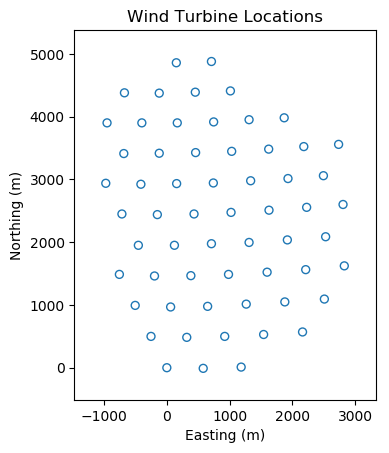

In [12]:
# add turbine locations to plot
for i = 1:length(turbine_x)
    plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), rotor_diameter[1]/2.0, fill=false,color="C0"))
end

# set up and show plot
axis("square")
plt.xlim([minimum(turbine_x)-500, maximum(turbine_x)+500])
plt.ylim([minimum(turbine_y)-500, maximum(turbine_y)+500])
plt.title("Wind Turbine Locations")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.show()